In [14]:
from datetime import datetime

from cartopy.crs import NorthPolarStereo
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import numpy as np
from scipy.interpolate import RegularGridInterpolator

from validate_on_nic_DMI import ValidationNIC_DMI
from sitacval import compute_stats
import sklearn.metrics as skm


In [2]:
def get_ice_type_mapping():
    ice_type_maping = np.zeros(100, int)
    #1 water
    ice_type_maping[0] = 1
    #2 - Young Ice (81, 82, 83, 84, 85)
    ice_type_maping[81] = 2
    ice_type_maping[82] = 2
    ice_type_maping[83] = 2
    ice_type_maping[84] = 2
    ice_type_maping[85] = 2
    #3 - Thin FY Ice (87, 88, 89)
    ice_type_maping[87] = 3
    ice_type_maping[88] = 3
    ice_type_maping[89] = 3
    #4 - Thick FY Ice (86, 91, 93)
    ice_type_maping[86] = 4
    ice_type_maping[91] = 4
    ice_type_maping[93] = 4
    #5 - MY Ice (95, 96, 97)
    ice_type_maping[95] = 5
    ice_type_maping[96] = 5
    ice_type_maping[97] = 5
    #6 - Glacier Ice (98)
    ice_type_maping[98] = 6
    return ice_type_maping

def get_ice_type_fractions(icecodes, CA, CB, CC, SA, SB, SC):
    ice_type_fractions = np.zeros((len(icecodes), 7))
    ice_type_fractions[range(len(icecodes)), SA] += CA
    ice_type_fractions[range(len(icecodes)), SB] += CB
    ice_type_fractions[range(len(icecodes)), SC] += CC
    ice_type_fractions[:, 1] = 100 - ice_type_fractions[:, 2:].sum(axis=1)
    return ice_type_fractions

def get_man_file(path):
    with Dataset(path) as ds:
        ct = ds['CT'][0].astype(int).filled(0)
        ca = ds['CA'][0].astype(int).filled(0)
        cb = ds['CB'][0].astype(int).filled(0)
        cc = ds['CC'][0].astype(int).filled(0)
        sa = ds['SA'][0].astype(int).filled(0)
        sb = ds['SB'][0].astype(int).filled(0)
        sc = ds['SC'][0].astype(int).filled(0)
        ice_poly_id_grid = ds['ice_poly_id_grid'][0, ::-1]
    return ct,ca,sa,cb,sb,cc,sc,ice_poly_id_grid

def correct_ca_cb_cc(CT, CA, CB, CC):
    CA[CA == -9] = CT[CA == -9]
    CB[CB == -9] = 0
    CC[CC == -9] = 0
    return CA, CB, CC

def correct_sa_sb_sc(SA, SB, SC, ice_type_maping):
    SA_SB_SC = []
    for s in [SA, SB, SC]:
        s[s  == -9] = 99
        SA_SB_SC.append(ice_type_maping[s])
    return SA_SB_SC

def get_sod_sic_maps(ice_type_fractions, ice_poly_id_grid, ct):
    sod = np.argmax(ice_type_fractions, axis=1)
    ice_poly_id_grid_int = ice_poly_id_grid.filled(0).astype(int)
    sic_map = ct[ice_poly_id_grid_int].astype(float)
    sic_map[ice_poly_id_grid.mask] = np.nan
    sod_map = sod[ice_poly_id_grid_int].astype(float) - 1
    sod_map[ice_poly_id_grid.mask] = np.nan
    return sod_map, sic_map

def reproject(src_crs, src_x, src_y, src_arrays, dst_crs, dst_x, dst_y):
    dst_x_grd, dst_y_grd = np.meshgrid(dst_x, dst_y)
    dst_x_grd_pro, dst_y_grd_pro, _ = src_crs.transform_points(dst_crs, dst_x_grd.flatten(), dst_y_grd.flatten()).T
    dst_arrays = []
    for src_array in src_arrays:
        rgi = RegularGridInterpolator((src_y, src_x), src_array, method='nearest', bounds_error=False)
        dst_array = rgi((dst_y_grd_pro, dst_x_grd_pro))
        dst_arrays.append(dst_array.reshape(dst_x_grd.shape))
    return dst_arrays

class ValidationDMI_DMI(ValidationNIC_DMI):
    map_label_aut = 'DMI-auto'
    map_label_man = 'DMI-manual'

    def get_aut_ice_chart(self, aut_files):
        aut_ice_chart = super().get_aut_ice_chart(aut_files)
        # MAN ICE CHART
        #		crs:proj4_string = " +proj=stere +lon_0=-45 +lat_ts=90 +lat_0=90 +a=6371000 +b=6371000" ;
        dst_crs = NorthPolarStereo(true_scale_latitude=90, central_longitude=-45)
        # AUTO ICE CHART
        # 		crs:proj4_string = "+proj=stere +lat_0=90 +lat_ts=70 +lon_0=-45 +x_0=0 +y_0=0 +a=6378273 +b=6356889.449 +units=m +no_defs" ;
        src_crs = NorthPolarStereo(true_scale_latitude=70, central_longitude=-45)
        x_min = -923125.7
        x_max = 1307874.2
        x_size = 2232

        y_min = -529677.75
        y_max = -3846677.8
        y_size = 3318

        xc = np.linspace(x_min, x_max, x_size)
        yc = np.linspace(y_min, y_max, y_size)
        aut_arrays_pro = reproject(
            src_crs,
            aut_ice_chart['xc'],
            aut_ice_chart['yc'],
            [aut_ice_chart['sic'], aut_ice_chart['sod'], aut_ice_chart['landmask']],
            dst_crs, xc, yc)
        return {
            'sic': aut_arrays_pro[0],
            'sod': aut_arrays_pro[1],
            'landmask': aut_arrays_pro[2],
        }

    def get_man_ice_chart(self, man_file):
        ice_type_maping = get_ice_type_mapping()
        ct,ca,sa,cb,sb,cc,sc,ice_poly_id_grid = get_man_file(man_file)
        cam, cbm, ccm = correct_ca_cb_cc(ct, np.array(ca), np.array(cb), np.array(cc))
        sam, sbm, scm = correct_sa_sb_sc(sa, sb, sc, ice_type_maping)
        ice_type_fractions = get_ice_type_fractions(cam, cam, cbm, ccm, sam, sbm, scm)
        sod_map, sic_map = get_sod_sic_maps(ice_type_fractions, ice_poly_id_grid, ct)
        return {
            'sic': sic_map,
            'sod': sod_map,
        }

    def find_manual_file(self, date):
        man_file = date.strftime(f'{self.dir_man}/%Y/%m/ice_conc_overview_greenland_%Y%m%d1200.nc')
        return man_file


In [3]:
%matplotlib inline
args_dir_man = '/Data/sat/auxdata/ice_charts/cmems_obs-si_arc_physic_nrt_1km-grl_P1WT3D-m_202012'
args_dir_aut = '/Data/sat/auxdata/ice_charts/dmi_asip_seaice_mosaic_arc_l3'
/Data/sim/data/OSISAF_ice_conc_amsr

args_dir_stats = 'dmi_dmi'

In [4]:
vn = ValidationDMI_DMI(args_dir_man, args_dir_aut, args_dir_stats)
vn.step = 10
date = datetime(2021,1,3)

#vn.process_date(date)
#raise
#man_file = '2021/01/ice_conc_overview_greenland_202101031200.nc'

#aut_files = vn.week_auto_files(date)
#aut_ice_chart = vn.get_aut_ice_chart(aut_files)
#man_ice_chart = vn.get_man_ice_chart(man_file)

In [5]:
man_file = vn.find_manual_file(date)
aut_files = vn.week_auto_files(date)
aut_ice_chart = vn.get_aut_ice_chart(aut_files)
man_ice_chart = vn.get_man_ice_chart(man_file)
diff, mask = vn.get_difference(man_ice_chart, aut_ice_chart)

Reading automatic ice chart from  /Data/sat/auxdata/ice_charts/dmi_asip_seaice_mosaic_arc_l3/dmi_asip_seaice_mosaic_arc_l3_20210102.nc
Reading automatic ice chart from  /Data/sat/auxdata/ice_charts/dmi_asip_seaice_mosaic_arc_l3/dmi_asip_seaice_mosaic_arc_l3_20210101.nc


/Home/antonk/py/sitac_validation/validate_on_nic_DMI.py:195: RuntimeWarning: All-NaN slice encountered
  'sod': np.nanmedian(sods, axis=2),
/Home/antonk/py/sitac_validation/validate_on_nic_DMI.py:196: RuntimeWarning: All-NaN slice encountered
  'sic': np.nanmedian(sics, axis=2),


In [7]:
aut_sod = np.round(aut_ice_chart['sod'][mask['sod']]).astype(int)
man_sod = np.round(man_ice_chart['sod'][mask['sod']]).astype(int)
stats = compute_stats(man_sod, aut_sod, vn.max_value['sod'])


/data1/antonk/miniconda/envs/ice2/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data1/antonk/miniconda/envs/ice2/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data1/antonk/miniconda/envs/ice2/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

In [20]:
skm.confusion_matrix(man_sod, aut_sod, labels=range(6))


array([[1305543,       0,    1313,     833,   12663,       0],
       [  11579,       0,   20372,     814,    6037,       0],
       [   6639,       0,  418569,    4390,    2929,       0],
       [      0,       0,    2518,   28537,    8863,       0],
       [   9079,       0,    6121,   12994,  619307,       0],
       [      0,       0,       0,       0,       0,       0]])

In [21]:
matrix = skm.confusion_matrix(man_pixels, aut_pixels)

NameError: name 'man_pixels' is not defined

In [32]:
p, r, f, s = skm.precision_recall_fscore_support(
    man_sod,
    aut_sod,
    average=None,
    labels=range(6)
)


/data1/antonk/miniconda/envs/ice2/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data1/antonk/miniconda/envs/ice2/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data1/antonk/miniconda/envs/ice2/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()}

In [38]:
dict(**np.load('./dmi_dmi/stats_20210103.npz'))['matrix']

array([[1.305543e+06,          nan, 1.313000e+03, 8.330000e+02,
        1.266300e+04,          nan],
       [1.157900e+04,          nan, 2.037200e+04, 8.140000e+02,
        6.037000e+03,          nan],
       [6.639000e+03,          nan, 4.185690e+05, 4.390000e+03,
        2.929000e+03,          nan],
       [         nan,          nan, 2.518000e+03, 2.853700e+04,
        8.863000e+03,          nan],
       [9.079000e+03,          nan, 6.121000e+03, 1.299400e+04,
        6.193070e+05,          nan],
       [         nan,          nan,          nan,          nan,
                 nan,          nan]])

In [39]:
ll /data1/antonk/tmp/S1A_EW_GRDM_1SDH_20240328T190738_20240328T190842_053186_0671B8_67A2.SAFE

total 36035976
-rw-r--r--   1 antonk    5984516 Apr 23 16:20  0.2mThresh_202001_10km_segment_TotalDC_modOIB.nc
-rw-r--r--   1 root    660617599 Dec 12  2023  20141004T061701.npz
-rw-r--r--   1 antonk   29275246 Aug  7 16:24  20170201_korosov_kinematics_roughness.pptx
-rw-r--r--   1 antonk    2070795 Aug  7 16:24  20170201_korosov_s2s3_fusion.pdf
-rw-r--r--   1 root    812624744 Dec 12  2023  20230622T064301_tg.tif
-rw-r--r--   1 root        98968 Dec 12  2023  20230622T064301_tg.tif_mask.npz
-rw-r--r--   1 root    812624744 Dec 12  2023  20230622T064301.tif
-rw-r--r--   1 root        98968 Dec 12  2023  20230622T064301.tif_mask.npz
-rw-r--r--   1 antonk  646225109 Dec 12  2023  20230622T064301.tif.npz
-rw-r--r--   1 antonk    3400981 Aug 18  2023  20230701_165204.heic
-rw-r--r--   1 antonk    3127919 Aug 18  2023  20230701_165204.jpg
-rw-r--r--   1 antonk    1775847 Aug 18  2023  20230703_105419.heic
-rw-r--r--   1 antonk    1947961 Aug 18  2023  20230703_105419.jpg
-rw-r--r--   1 anto

In [1]:
from osgeo import gdal
from nansat import Nansat

In [21]:
ds = gdal.Open('/data1/antonk/tmp/S1A_EW_GRDM_1SDH_20240328T190738_20240328T190842_053186_0671B8_67A2.SAFE')

In [22]:
a = ds.ReadAsArray()

In [24]:
b = ds.GetRasterBand(1)

In [25]:
ba = b.ReadAsArray()

In [26]:
ba.shape

(10709, 10398)

In [3]:
n = Nansat('/data1/antonk/tmp/S1A_EW_GRDM_1SDH_20240328T190738_20240328T190842_053186_0671B8_67A2.SAFE')

In [12]:
ll /data1/antonk/tmp/S1A_EW_GRDM_1SDH_20240328T190738_20240328T190842_053186_0671B8_67A2.SAFE/measurement/s1a-ew-grd-hh-20240328t190738-20240328t190842-053186-0671b8-001.tiff

-rw-rw-r-- 1 antonk 222899672 Mar 28 19:34 /data1/antonk/tmp/S1A_EW_GRDM_1SDH_20240328T190738_20240328T190842_053186_0671B8_67A2.SAFE/measurement/s1a-ew-grd-hh-20240328t190738-20240328t190842-053186-0671b8-001.tiff


In [ ]:
from s1de

In [17]:
n = Nansat('/data1/antonk/tmp/S1A_EW_GRDM_1SDH_20240328T190738_20240328T190842_053186_0671B8_67A2.SAFE/measurement/s1a-ew-grd-hh-20240328t190738-20240328t190842-053186-0671b8-001.tiff')

In [29]:
n.vrt.

18X3OXXDT4.vrt

In [28]:
n = Nansat('/data1/antonk/tmp/S1A_EW_GRDM_1SDH_20240328T190738_20240328T190842_053186_0671B8_67A2.SAFE')

In [18]:
n.reproject_gcps()
n.vrt.tps = True

In [19]:
n.transform_points([1],[1])

(array([-28.3501511]), array([63.18513025]))

(array([-28.33162342]), array([63.18259353]))

In [51]:
hh = n['sigma0_HH']

In [64]:
hv = n['sigma0_HV']

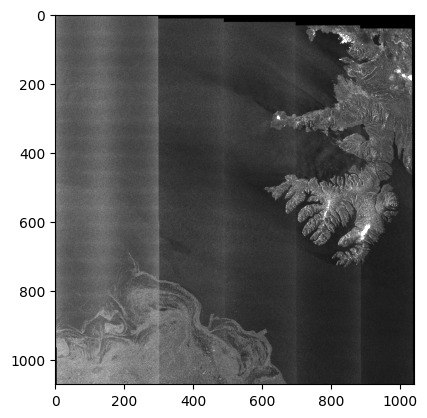

In [63]:
%matplotlib inline
plt.imshow(a[1, ::10, ::10], cmap='gray', clim=[0, 300])
plt.show()

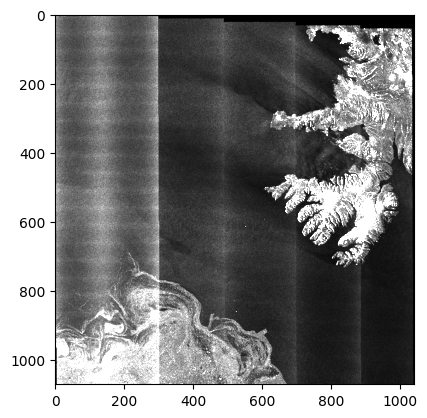

In [66]:
plt.imshow(hv[::10, ::10], cmap='gray', clim=[0, 0.01])